<h1 style="text-align: center;"><img src="img/logo_servicex.png" width="70" height="70" style="float:left" alt="ServiceX"><img src="img/logo_irishep.png" width="70" height="70" style="float:right" alt="IRIS-HEP">IRIS-HEP ServiceX Tutorial</h1>

<h4 style="text-align: center;">[Artur Cordeiro Oudot Choi] (IRIS-HEP)</h4><h4 style="text-align: center;">IRIS-HEP Analysis Software Training Event (July 2025)</h4>

---

## 1 – Introduction to ServiceX

- **Managing Datasets for physics at the LHC**
 
  The experimental data and simulations needed for full-scale analyses at LHC experiments are too large to be stored locally. Only fractions of such datasets (DS) are downloaded to accessible user storage for small projects / R&D purposes.

  The current DS management workflow of physics analyses consists of:
  - Requests for large storage spaces for each analysis team (`eos`, `groupsdisk`)
  - Institute-provided machines
  - Sending ntuplizer jobs on the grid to skim DS
      -  event pre-selection, triggers, working points
      -  High-level variable construction, dropping low-level information
  - Downloading full or partial DS with `rucio`
  - Managing all productions
      - Deleting older files
      - requesting DS persistence exceptions
      - requesting larger group storage



- **What is ServiceX**?

  ServiceX is a data transformation and delivery system that simplifies the data access workflow for physics analyses. The system is deployed on a Kubernetes cluster, allowing quick and scalable operations with parallel transformers and access to multiple services.
  It is a project of IRIS-HEP DOMA (Data Organization, Management And Access) to interface centrally produced datasets and user-level analysis code for the HL-LHC. Larger data volumes will pose more difficulty for physics analyses.
  
  ServiceX offers physicists the possibility to :
    - Pull only the columns or features needed, without having to download multi-TB files or run grid jobs.
    - Apply cuts to data, delivering only a portion of events
        - Quickly prototype cutflows
        - Target studies on unusual events, calibration errors... 
    - Integrate analyses in a Python-based framework (`coffea` , `RDataFrame`)
    - Work with multiple data formats on the same system (xAOD, DAOD, Ntuple Trees, RNTP, parquet)
    - Access different storage (`rucio`, `eos`, `CernOpenData`)
    - Run only a lightweight python package and not a large ATLAS software environment on remote machines.
    - Apply complex transformations on just a few lines of code

    

 - **How does it work?**
   
     - Query-based data transformation and delivery: Users send HTTPS requests to the ServiceX Web API using the [client library](https://github.com/ssl-hep/ServiceX_frontend). Each request contains an input sample name and all cuts/ data transformations to be dumped in the result file.
  
     - Remote data access: The Web API sends the requested sample name to a Dataset Finder service which sotres it via the Grid or XRootD to an XCache. ServiceX can also be deployed on a grid site which would maximize bandwith. 
  
     - Code Generation: The generated code is built from the query specifications sent to the Web API. ServiceX builds this Python or C++ code by leveraging abstract syntax trees and functional programming. This means users can express complex data processing in a few lines. Multiple query types are available with different syntax/code translation. Additionaly, one can instead send a custom python function to be executed in the backend.

     - Transformers and science images: To execute the generated code, kubernetes deploys transformer pods. Depending on the request, these pods require different environments. Each query type has its science image used to build containers. These can include python environements with awkward, uproot, RDataFrame and Root or Atlas software like AnalysisBase or TopCPToolkit...  The number of transformers deployed for one request scales with the number of files to be acessed in the requested dataset. By parallelizing the work of multiple files and merging the outputs, servicex delivers the results fast.
  
     - Object store: Transformed outputs are written to an S3-compatible store; users download just URLs or files as they become available.


    (insert your diagram of the client → ServiceX API → transformer pods flow.)

 
- **Minimal setup**
  
    - ServiceX Front-end: A minimal Python library (client API), for defining queries and sending HTTPS queries to the web api
    - ServiceX Back-end: The kubernetes system containing all microservices in static pods and transformer pods that execute the data transformation. This is deployed at an analysis facility. 

  As a user you only interact with the client API (python script or with command lines) but you need a token that grants access to one end-point. 

This simple setup means that you can run ServiceX from anywhere: laptops, office machine, jupyter hub... 

For any information on the client API please check the [documentation](https://servicex-frontend.readthedocs.io)


![Transformer Diagram Placeholder](img/placeholder_transformer.png)
![Data Flow Placeholder](img/placeholder_dataflow.png)

The rest of this notebook is a hands on Tutorial

For ATLAS users the end-point is at af.UChicago. Download your `servicex.yaml` from the ServiceX web portal.

## 2 – Installation

### 2a - Client package


ServiceX Front end explanation :

In [1]:
!pip install servicex

### 2b - Utilities package


ServiceX analysis utils explanation :

In [2]:
!pip install servicex_analysis_utils

  Using cached servicex_analysis_utils-1.0.3-py3-none-any.whl.metadata (3.0 kB)
Using cached servicex_analysis_utils-1.0.3-py3-none-any.whl (11 kB)


### 2c - Access to endpoint


ServiceX at Uchicago explanation + now can create account with CERN SSO ATLAS :

In [3]:
import os
assert os.path.exists('servicex.yaml'), 'servicex.yaml not found in working directory'

## 3 – Building Your First ServiceX Request


In [4]:
#Import needed packages 
from servicex import deliver, query, dataset
from servicex_analysis_utils import to_awk

### 3.1 Runing a python function in the backend
Amongsts the different trasnformer types ServiceX provides trasnformer that distribute a user-written python function with uproot and awkward  

#### a - Building the query event selection

In [5]:
#The user function

def run_query(input_filenames):
    import uproot
    import awkward as ak
    """
    input_filenames : 
        The dataset specified in the query
    treename : str
      Name of the TTree inside each file
    Returns
    -------
    ak.Array with fields truth_alp_decayVtxX, truth_alp_decayVtxY, jet_pt_NOSYS
    for events passing the selection cuts

    Will be sent to ServiceX's object store
    """
    # 1) Load the branches into a single awkward array
    treename="reco"
    branches = [
        "truth_alp_decayVtxX",
        "truth_alp_decayVtxY",
        "truth_alp_pt",
        "truth_alp_eta",
        "jet_EMFrac_NOSYS", 
        "jet_pt_NOSYS",
    ]
    # uproot.open accepts a glob or list
    with uproot.open(input_filenames) as f:
        tree = f[treename]
        arr = tree.arrays(branches, library="ak")

    # 2) Build the mask
    mask = ak.ravel(
        (abs(arr["truth_alp_eta"]) < 0.8) &
        (arr["truth_alp_pt"] > 20) &
        (ak.num(arr["jet_EMFrac_NOSYS"]) < 2)
    )

    # 3) Zip only the three output fields, applying the mask
    out = ak.zip({
        "truth_alp_decayVtxX": arr["truth_alp_decayVtxX"][mask],
        "truth_alp_decayVtxY": arr["truth_alp_decayVtxY"][mask],
        "jet_EMFrac_NOSYS":       arr["jet_EMFrac_NOSYS"][mask]
    }, depth_limit=1)

    return out

In [6]:
python_query=query.PythonFunction().with_uproot_function(run_query)

#### b - Selecting the dataset

In [7]:
my_DS="user.acordeir:michigan-tutorial.displaced-signal.root" 
#In CERN Scratch Disk
request_DS=dataset.Rucio(my_DS)

#### c - Build the ServiceX request spec

In [8]:
# Define a simple query
spec = {
    'Sample': [{
        'Name': 'My_first_transform',
        'Dataset': request_DS,
        'Query': python_query
    }]
}

d - Send the request to the Web API

In [9]:
# Deliver the request
transformed_results = deliver(spec)

Output()

By default, ServiceX results are downloaded from the object store into the user's cache `tmp/servicex_$user/`

In [42]:
# Delivered results on tmp storage
print(transformed_results)

{'My_first_transform': ['/tmp/servicex_acordeir/15c023e3-0e92-41fc-8a3e-c8b880920c67/root___c112.af.uchicago.edu_1094__root___eosatlas.cern.ch_1094__eos_atlas_atlasscratchdisk_rucio_user_acordeir_2c_e6_0p4GeV_alp_med_prod2.root']}


### 3.2 - Quick analysis example 
 ServiceX data delivery is particularly usefull for fast dataset exploration, specific studies. It is straigthforward to integrated it in small python scripts that analyse some physics feautres.

In [11]:
import matplotlib.pyplot as plt
import awkward as ak

def analyse(results, name):
    # extract your array with analysis_utils
    arr = to_awk(results)[name]

    # compute displacement 
    displacement = (arr["truth_alp_decayVtxX"]**2 +
                    arr["truth_alp_decayVtxY"]**2)**0.5

    # flatten the awkward arrays
    emfrac = ak.flatten(arr["jet_EMFrac_NOSYS"])
    disp   = ak.flatten(displacement)

    # set up side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))

    # EM fraction
    axes[0].hist(emfrac, bins=50, range=[0,1] )
    axes[0].set_title(f" Jet EM Fraction")
    axes[0].set_xlabel("EM Fraction")
    axes[0].set_ylabel("Counts")

    # displacement
    axes[1].hist(disp, bins=50, range=[0,5000], color="g")
    axes[1].set_title(f"Decay Vertex Displacement")
    axes[1].set_xlabel("Displacement in x-y (mm)")
    axes[1].set_ylabel("Counts")

    plt.tight_layout()
    plt.show()


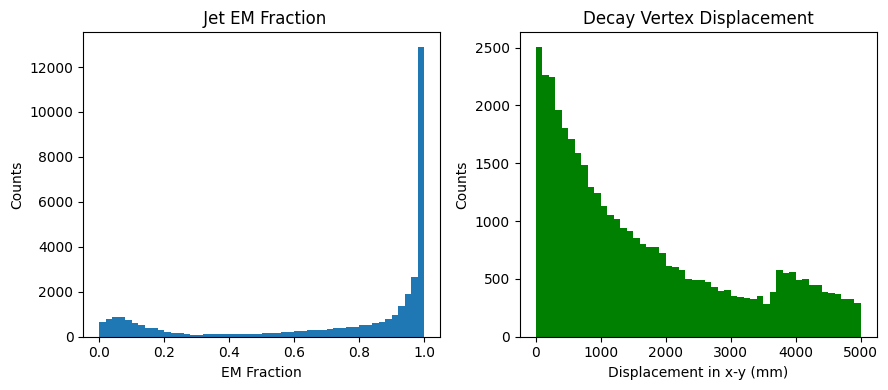

In [12]:
analyse(transformed_results, "My_first_transform")

 Descrbide and emphasize how fast this was compared to have to -> go to lxplus and download with rucio, open the specific file in the path you downloaded, run trouthg the file for all skimming etc etc 

## 4 – Other Transformer Types for skimming root files

### Same workflow on other stuff

**Uproot** used directly in a more functional language 
cut parsed as string using awkward reducers

num, count, count_nonzero, any, all, sum, prod, min, max, argmin, argmax, mean, var, std


In [13]:
uproot_raw_query=query.UprootRaw([{
    'treename':'reco',
    'filter_name':
      [ "truth_alp_decayVtxX",
        "truth_alp_decayVtxY",
        "truth_alp_pt",
        "truth_alp_eta",
        "jet_EMFrac_NOSYS", 
        "jet_pt_NOSYS" ],
    'cut':
        '(num(jet_pt_NOSYS)<2) & any((truth_alp_pt>20) & (abs(truth_alp_eta)<0.8))'}])
        

In [14]:
# UprootRaw example
spec_upraw = {
    'Sample': [{
        'Name': 'UprootRawExample',
        'Dataset': request_DS,
        'Query': uproot_raw_query
    }]
}

In [15]:
results_uproot_raw=deliver(spec_upraw)

Output()

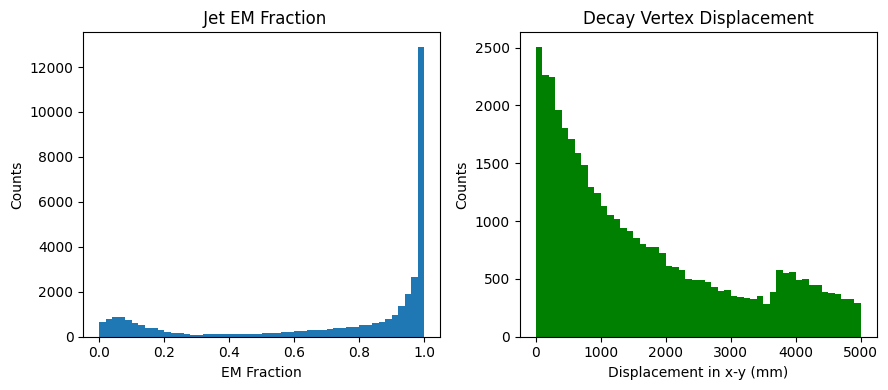

In [16]:
analyse(results_uproot_raw, "UprootRawExample")

Same exact result, however the branches you load are the branches you dump 

UprootRaw also offers copy histograms! Example here 

Multi sample call here as well 

Func ADL uproot or Xaod 
func_adl is an SQL-like language used to construct hierarchical data queries for servicex. func_adl is written to work with both servicex service modes, and requires either func_adl_xAOD or func_adl_uproot for full functionality.

In [37]:
#The selection functions must return a boolean
def jet_cut(evt) -> bool:
    return evt["jet_pt_NOSYS"].Count() < 2

def alp_pt_cut(evt) -> bool:
    # at least one ALP with pT > 20
    return evt["truth_alp_pt"].Where(lambda pt: pt > 20).Count() > 0

def alp_eta_cut(evt) -> bool:
    # at least one ALP with |η| < 0.8
    return evt["truth_alp_eta"].Where(lambda eta: abs(eta) < 0.8).Count() > 0

simple_query = query.FuncADL_Uproot() \
    .FromTree("reco") \
    .Where(jet_cut) \
    .Where(alp_pt_cut) \
    .Where(alp_eta_cut) \
    .Select(lambda e: {
        "jet_EMFrac_NOSYS":  e["jet_EMFrac_NOSYS"],
        "truth_alp_decayVtxX":  e["truth_alp_decayVtxX"],
        "truth_alp_decayVtxY": e["truth_alp_decayVtxY"],
    })


In [18]:
spec_funcadl = {
    'Sample': [{
        'Name': 'FuncADLExample',
        'Dataset': request_DS,
        'Query': simple_query
    }]
}

In [38]:
result_funcadl=deliver(spec_funcadl)

NameError: name 'spec_funcadl' is not defined

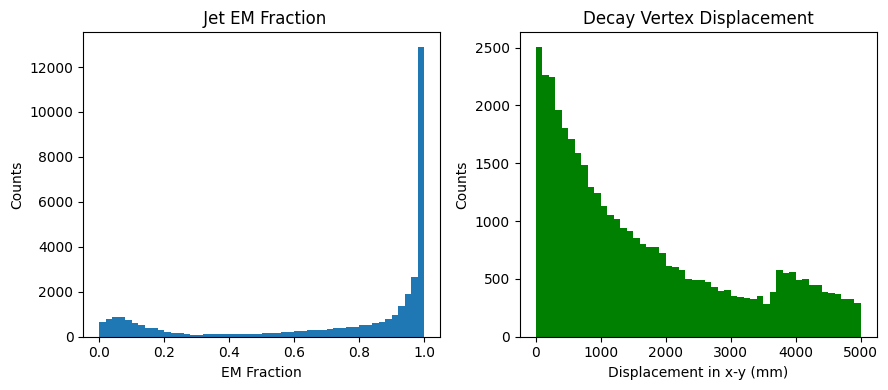

In [20]:
analyse(r, "FuncADLExample")

## 5 - ATLAS software transforms for xAOD

Smth about func adl xADO

In [19]:
#LLP1 DAOD

DAOD="mc23_13p6TeV:mc23_13p6TeV.601806.PhPy8EG_AZNLO_ggH125_mA0p4_medium.deriv.DAOD_LLP1.e8526_e8528_s4111_s4114_r14622_r14663_p6368"
request_daod=dataset.Rucio(DAOD)

In [70]:
query_adl = query.FuncADL_ATLASr22()
truth_stream = query_adl.Select(
    lambda e: e
        .TruthParticles("TruthBSMWithDecayParticles")
        .Where(lambda p: p.absPdgId() == 35)
)

# now map to a dict of decay‐vertex coords
truth_info = truth_stream.Select(
    lambda ts: {
        "LLP_Lxy": ts.Select(lambda p: (p.decayVtx().x()**2 + p.decayVtx().y()**2)**0.5),
    }
)

In [98]:
spec = {
    "Sample": [
        {
            "Name": "func_adl_xAOD_simple",
            "Dataset": request_daod,
            "Query": truth_info,
            "NFiles": 1,
        }
    ]
}
files = deliver(spec)

Output()

In [103]:
Lxy=to_awk(files)["func_adl_xAOD_simple"]["LLP_Lxy"]
print(
    f"The BSM particle has a truth displacement mean of {ak.mean(Lxy): .2f} mm \
    \nApproximately {ak.count_nonzero(Lxy<1000)/len(Lxy)*100 :.1f} % of events have secondary vertices in ATLAS's tracker area"
)

The BSM particle has a truth displacement mean of  1812.80 mm     
Approximately 47.4 % of events have secondary vertices in ATLAS's tracker area


The xAOD support in func ADL allows users to use ATLAS software from any machine using ServiceX with very fast results.  

Reminder:

The standard workflow to reach this result with a DAOD would involve: Connecting to a machine (lxplus), setting up ATLAS tools, downloading one file from the rucio DID, writing an AnalysisBase or Athena package in C++ to access the objects and do the computation you seek; compile everything in the correct release, write down in a python config file all the flags you need and the input file paths.     

For larger operations one might have to configure ATLAS `panda` to distribute the job on the GRID


###  ServiceX dashboard, errors logs 
- Image of moninotring transforms 
- image of errors 

In [ ]:
#Example of error in transformer execution

def run_query(input_filenames):
    return non_defined_variable

error_query=query.PythonFunction().with_uproot_function(run_query)

spec = {
    "Sample": [
        {
            "Name": "error_example",
            "Dataset": request_DS,
            "Query": error_query,
            "NFiles": 1,
        }
    ]
}
deliver(spec)

## 5 - Optionnal functionalities 
- Request specifications: 
    - `General` block
        - `OutputFormat` for root-file or parquet
        - `Delivery` to download files to LocalCache or get SignedURLs to the S3 store
        - Multiple `Sample` sub-blocks can be added. This allows different transforms per deliver call. 

    - `Sample` sub-block
        - `NFiles` to choose the number of files to transform for each dataset 
    - UprootRaw queries
        - `copy_histogram` This transformer type can directly copy Root histograms from the original file
- `deliver` function
    - `backend`: the end-point server can be manually selected
    - `config_path`: the path to your servicex.yaml token
    - `spec_file`: Can be used to import the transform specification from a .yaml file
    -  Command line version for sending ServiceX trasnfoms from the shell

       **Example below**

In [36]:
#Executing from the terminal with spec file
!servicex deliver spec_file_example.yaml

Delivering spec_file_example.yaml to ServiceX cache
5l
{
    'CLI-Testing': 
['/tmp/servicex_acordeir/92951a25-6b20-4241-b15e-fb30f6c2f659/root___c112.af.uch
icago.edu_1094__root___dcgftp.usatlas.bnl.gov_1094__pnfs_usatlas.bnl.gov_LOCALGR
OUPDISK_rucio_user_mtost_00_05_user.mtost.43325207._000108.all_with_sys.root']
}


In [41]:
!cat spec_file_example.yaml

Sample:
  - Name: CLI-Testing
    Dataset: !Rucio user.mtost:user.mtost.all.Mar11
    NFiles: 1
    Query: !UprootRaw |
      [{"treename": "reco",
        "cut": "any(log(jet_GN2v01_pc / ((jet_GN2v01_pb * 0.3) + (jet_GN2v01_pu * (1 - 0.3)))) > 0.828, axis=1)", 
        "filter_name": ["mu_phi", "mu_eta", "mu_charge", "mu_e*", "mu_pt*"]
        },
        {"copy_histograms": ["CutBookkeeper*", "cflow*", "metadata", "listOfSystematics"]}
        ]
      


## 5 – Remote file introspection with ServiceX

- For building ServiceX queries you need to know you dataset structure.
    -  TTrees/branch names
    -  available xAOD containers and decorations 
    -  Level of array nesting

In [ ]:
from servicex_analysis_utils import get_structure

structure_string=get_structure(DAOD)
print(structure_string)

You get the full Tree structure of your dataset in a few seconds. Including the name of TTrees, TBranches, base types, and levels of nesting (Jaggness). 

It also allows you to check what are the xAOD container names on AOD and DAOD root files and allows branch name filtering. 



## 6 – Free practice 

- Now that you have the building blocks to request a data transformation feel free to try any data skimming using ServiceX.
- You can use either of the datasets `request_DS` or `request_daod`, or one that you might be familiar with.
- Try to use different transformer types `PythonFunction`, `UprootRaw`, `Fund_ADL_Uproot`, `Func_ADL_xAOD`.
- Remeber to  the `get_structure` function to see what is available in the datasets.
- Try to make the best use of declarative syntax with the functional language queries.

 #### Exercise suggestion 1:
 - Compute the invariant mass of the 2-lepton system
 - Select events with exactly 2 opposite-charge electrons or muons


Formula reminder for 2 reco objects:

 $\quad\quad$  $M^2 = 2 p_{T1} p_{T2} \left( \cosh(\eta_1 - \eta_2) - \cos(\phi_1 - \phi_2) \right)$

 #### Exercise suggestion 2:
  - Compute the invariant mass of the lepton-lepton-jet (leading) system on the LLP datasets
  - Implement a 40 GeV pt cut on the truth BSM particle (ALP)
  - Select events with exactly 2 opposite-charge leptons
  - Use Lorentz vectors
